# Import libraries

In [97]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
import torch.nn.init as init

# Load Data

In [98]:
N=5
T_exploration = 100
T_stat = 600
T_jump = 10

In [99]:
file_x = f"Numpy_array_save/N={N}_quadraticPath/X_train.npy"
file_z = f"Numpy_array_save/N={N}_quadraticPath/Z_train.npy"
file_y = f"Numpy_array_save/N={N}_quadraticPath/Y_train.npy"
# file_y_sanity = f"Numpy_array_save/N={N}_quadraticPath/Y_sanity_train.npy"

X_train = np.load(file_x)
Y_train = np.load(file_y)
Z_train = np.load(file_z)
# Y_sanity_train = np.load(file_y_sanity)

In [100]:
file_x = f"Numpy_array_save/N={N}_quadraticPath/X_valid.npy"
file_z = f"Numpy_array_save/N={N}_quadraticPath/Z_valid.npy"
file_y = f"Numpy_array_save/N={N}_quadraticPath/Y_valid.npy"
# file_y_sanity = f"Numpy_array_save/N={N}_quadraticPath/Y_sanity_valid.npy"

X_valid = np.load(file_x)
Y_valid = np.load(file_y)
Z_valid = np.load(file_z)
# Y_sanity_valid = np.load(file_y_sanity)

In [101]:
# Print Shape for sanity
print(f"X Shape: {X_train.shape}")
print(f"Y Shape: {Y_train.shape}")
print(f"Z Shape: {Z_train.shape}")

X Shape: (25000, 202)
Y Shape: (25000, 60)
Z Shape: (25000, 122)


# Normalize Data(Optional)

In [102]:
# Normalize process
X_mean = np.mean(X_train, axis=0)
X_std = np.std(X_train, axis=0)
print(f"Mean: {X_mean}   STD: {X_std}")

X_mean[-2], X_mean[-1] = 0, 0
X_std[-2], X_std[-1] = 1, 1

epsilon = 0.01
X_train = (X_train - X_mean) / (X_std + epsilon)
X_valid = (X_valid - X_mean) / (X_std + epsilon)


Mean: [6.04507031e-01 5.90794516e-01 8.04507031e-01 9.93340637e-01
 1.20450703e+00 2.14082239e+00 1.80450703e+00 4.71801879e+00
 2.60450703e+00 9.75209835e+00 3.60450703e+00 1.86126191e+01
 4.80450703e+00 3.30115286e+01 6.20450703e+00 5.50031639e+01
 7.80450703e+00 8.69842516e+01 9.60450703e+00 1.31693908e+02
 1.16045070e+01 1.92213638e+02 1.38045070e+01 2.71967337e+02
 1.62045070e+01 3.74721290e+02 1.88045070e+01 5.04584170e+02
 2.16045070e+01 6.66007042e+02 2.46045070e+01 8.63783358e+02
 2.78045070e+01 1.10304896e+03 3.12045070e+01 1.38928208e+03
 3.48045070e+01 1.72830335e+03 3.86045070e+01 2.12627576e+03
 4.26045070e+01 2.58970473e+03 4.68045070e+01 3.12543804e+03
 5.12045070e+01 3.74066588e+03 5.58045070e+01 4.44292080e+03
 6.06045070e+01 5.24007778e+03 6.56045070e+01 6.14035415e+03
 7.08045070e+01 7.15230966e+03 7.62045070e+01 8.28484644e+03
 8.18045070e+01 9.54720899e+03 8.76045070e+01 1.09489842e+04
 9.36045070e+01 1.25001015e+04 9.98045070e+01 1.42108323e+04
 1.06204507e+02 1.

In [103]:
# Save Xmean and std
file_x_mean = f"Numpy_array_save/N={N}_quadraticPath/X_mean.npy"
file_x_std = f"Numpy_array_save/N={N}_quadraticPath/X_std.npy"

np.save(file_x_mean, X_mean)
np.save(file_x_std, X_std)

# Prepare Data To Training

In [104]:
X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32)
Z_train = torch.tensor(Z_train, dtype=torch.float32)

X_valid = torch.tensor(X_valid, dtype=torch.float32)
Y_valid = torch.tensor(Y_valid, dtype=torch.float32)
Z_valid = torch.tensor(Z_valid, dtype=torch.float32)

In [105]:
train_dataset = TensorDataset(X_train, Z_train, Y_train)
val_dataset = TensorDataset(X_valid, Z_valid, Y_valid)

# Define NN

In [106]:
class Quadratic_NN(nn.Module):
    def __init__(self, input_size, output_size):
        super(Quadratic_NN, self).__init__()

        # Define layers
        self.fc0 = nn.Linear(input_size, 256)
        self.fc1 = nn.Linear(256, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, output_size)

        # Initialize weights
        self.init_weights()

    def forward(self, x):
        x = F.relu(self.fc0(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)

# Train Parameters

In [107]:
input_size = X_train.shape[-1]
output_size = 1 # qnn
print(f"input_size: {input_size}, output_size: {output_size}")

input_size: 202, output_size: 1


In [108]:
# Parameters
num_epochs = 15
batch_size = 64
lr_init = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Quadratic_NN(input_size, output_size).to(device=device)
criterion = nn.MSELoss() # Mean squared error loss
# criterion = nn.L1Loss()
# optimizer = optim.SGD(model.parameters(), lr=lr_init, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
scheduler = StepLR(optimizer, step_size=10, gamma=1)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# Train loop

In [109]:
train_list = []
valid_list = []
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for inputs_pre, inputs, targets in train_loader:
        # Squeeze the input tensor to match the Fc size
        inputs_pre, inputs, targets = inputs_pre.to(device), inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        qnn = model(inputs_pre)
        # Extract Parameters
        xn = inputs[:, 0:2*(T_stat//T_jump):2]
        cn = inputs[:, 1:2*(T_stat//T_jump):2]
        b = inputs[:, -2].unsqueeze(1).expand(-1, (T_stat//T_jump))  # Expands without copying memory
        # Calculate prior estimation
        inner_prod = (2 * (cn - b * xn) + qnn * (xn ** 2)) / (2 * xn + 1e-6)
        outputs = inner_prod - xn * qnn
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    scheduler.step()  # Update the learning rate

    # Validate
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs_pre, inputs, targets in val_loader:
            # Squeeze the input tensor to match the Fc size
            inputs_pre, inputs, targets = inputs_pre.to(device), inputs.to(device), targets.to(device)
            qnn = model(inputs_pre)
            # Extract Parameters
            xn = inputs[:, 0:2*(T_stat//T_jump):2]
            cn = inputs[:, 1:2*(T_stat//T_jump):2]
            b = inputs[:, -2].unsqueeze(1).expand(-1, (T_stat//T_jump))  # Expands without copying memory
            # Calculate prior estimation
            inner_prod = (2 * (cn - b * xn) + qnn * (xn ** 2)) / (2 * xn + 1e-6)
            outputs = inner_prod - xn * qnn
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)

    train_loss /= len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)
    train_list.append(train_loss)
    valid_list.append(val_loss)
    lr_value = optimizer.param_groups[0]["lr"]
    print(f"Epoch [{epoch+1}/{num_epochs}] Learning Rate:{lr_value} - "
          f"Train Loss: {train_loss:.5f}, Val Loss: {val_loss:.5f}")

Epoch [1/15] Learning Rate:0.001 - Train Loss: 0.76114, Val Loss: 0.14142
Epoch [2/15] Learning Rate:0.001 - Train Loss: 0.18151, Val Loss: 0.12774
Epoch [3/15] Learning Rate:0.001 - Train Loss: 0.17656, Val Loss: 0.09816
Epoch [4/15] Learning Rate:0.001 - Train Loss: 0.12431, Val Loss: 0.09952
Epoch [5/15] Learning Rate:0.001 - Train Loss: 0.11506, Val Loss: 0.08735
Epoch [6/15] Learning Rate:0.001 - Train Loss: 0.11890, Val Loss: 0.08758
Epoch [7/15] Learning Rate:0.001 - Train Loss: 0.10260, Val Loss: 0.08110
Epoch [8/15] Learning Rate:0.001 - Train Loss: 0.10439, Val Loss: 0.10610
Epoch [9/15] Learning Rate:0.001 - Train Loss: 0.09810, Val Loss: 0.10104
Epoch [10/15] Learning Rate:0.001 - Train Loss: 0.09639, Val Loss: 0.08468
Epoch [11/15] Learning Rate:0.001 - Train Loss: 0.09293, Val Loss: 0.08408
Epoch [12/15] Learning Rate:0.001 - Train Loss: 0.09470, Val Loss: 0.09042
Epoch [13/15] Learning Rate:0.001 - Train Loss: 0.10079, Val Loss: 0.08730
Epoch [14/15] Learning Rate:0.001 

# Plot train Graph

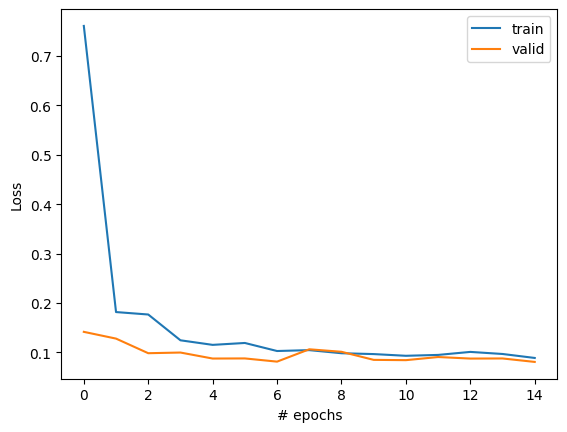

In [110]:
epochs = np.arange(num_epochs)
plt.plot(epochs, train_list, label='train')
plt.plot(epochs, valid_list, label='valid')
plt.xlabel("# epochs"), plt.ylabel("Loss"), plt.legend()
plt.show()

# Plot scatter label vs prediction

In [111]:
file_x = f"Numpy_array_save/N={N}_quadraticPath/X_valid.npy"
file_y_sanity = f"Numpy_array_save/N={N}_quadraticPath/Y_sanity_valid.npy"

X_valid = np.load(file_x)
Y_sanity_valid = np.load(file_y_sanity)

In [112]:
X_valid = (X_valid - X_mean) / (X_std + epsilon)

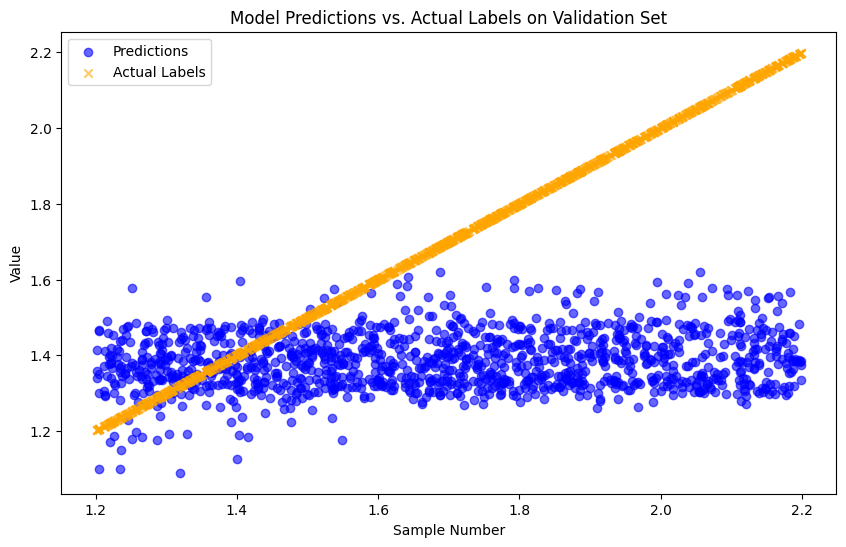

In [113]:
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    outputs = model(torch.tensor(X_valid,dtype=torch.float32).to(device))
    all_preds.append(outputs.cpu().numpy())
    all_targets.append(Y_sanity_valid)


# Convert lists to arrays
all_preds = np.concatenate(all_preds, axis=0).flatten()
all_targets = np.concatenate(all_targets, axis=0).flatten()


# Plot the predictions vs. actual labels as a scatter plot
jump = 2
plt.figure(figsize=(10, 6))
plt.scatter(all_targets[0:len(all_preds):jump], all_preds[0:len(all_preds):jump], label='Predictions', color='blue', marker='o', alpha=0.6)
plt.scatter(all_targets[0:len(all_preds):jump], all_targets[0:len(all_preds):jump], label='Actual Labels', color='orange', marker='x', alpha=0.6)
plt.xlabel('Sample Number')
plt.ylabel('Value')
plt.title('Model Predictions vs. Actual Labels on Validation Set')
plt.legend()
plt.show()

# Save model Results

In [139]:
PATH = './QuadraticPath_Net(N=5).pth'
torch.save(model.state_dict(), PATH)
print("Finsh")

Finsh
